In [2]:
import demo_util
import numpy as np
import torch
from PIL import Image
import imagenet_classes
from IPython.display import display
import os
from huggingface_hub import hf_hub_download
from modeling.maskgit import ImageBert
from modeling.titok import TiTok

In [2]:
# load the pretrained models from huggingface
# supported tokenizer: [tokenizer_titok_l32_imagenet, tokenizer_titok_b64_imagenet, tokenizer_titok_s128_imagenet]
# titok_tokenizer = TiTok.from_pretrained("yucornetto/tokenizer_titok_l32_imagenet")
# titok_generator = ImageBert.from_pretrained("yucornetto/generator_titok_l32_imagenet")

# or alternatively, downloads from hf
# hf_hub_download(repo_id="fun-research/TiTok", filename="tokenizer_titok_l32.bin", local_dir="./")
# hf_hub_download(repo_id="fun-research/TiTok", filename="generator_titok_l32.bin", local_dir="./")

In [3]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.manual_seed(0)

## Prepare the TiTok models

In [4]:
config = demo_util.get_config("configs/infer/TiTok/titok_l32.yaml")

In [5]:
print(config)

{'experiment': {'tokenizer_checkpoint': 'tokenizer_titok_l32.bin', 'generator_checkpoint': 'generator_titok_l32.bin', 'output_dir': 'titok_l_32'}, 'model': {'vq_model': {'codebook_size': 4096, 'token_size': 12, 'use_l2_norm': True, 'commitment_cost': 0.25, 'vit_enc_model_size': 'large', 'vit_dec_model_size': 'large', 'vit_enc_patch_size': 16, 'vit_dec_patch_size': 16, 'num_latent_tokens': 32, 'finetune_decoder': True}, 'generator': {'model_type': 'ViT', 'hidden_size': 768, 'num_hidden_layers': 24, 'num_attention_heads': 16, 'intermediate_size': 3072, 'dropout': 0.1, 'attn_drop': 0.1, 'num_steps': 8, 'class_label_dropout': 0.1, 'image_seq_len': '${model.vq_model.num_latent_tokens}', 'condition_num_classes': 1000, 'randomize_temperature': 9.5, 'guidance_scale': 4.5, 'guidance_decay': 'linear'}}, 'dataset': {'preprocessing': {'crop_size': 256}}}


In [6]:
# supported tokenizer: [tokenizer_titok_l32_imagenet, tokenizer_titok_b64_imagenet, tokenizer_titok_s128_imagenet]
titok_tokenizer = TiTok.from_pretrained("yucornetto/tokenizer_titok_l32_imagenet")
titok_tokenizer.eval()
titok_tokenizer.requires_grad_(False)
# or alternatively, downloads from hf

# hf_hub_download(repo_id="fun-research/TiTok", filename="tokenizer_titok_l32.bin", local_dir="./")
# titok_tokenizer = demo_util.get_titok_tokenizer(config)

print(titok_tokenizer)

TiTok(
  (encoder): TiTokEncoder(
    (patch_embed): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): ModuleList(
      (0-23): 24 x ResidualAttentionBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (conv_out): Conv2d(1024, 12, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): TiTokDecoder(
    (decoder_embed): Linear(in_features=12, out_

In [7]:
# supported generator: [generator_titok_l32_imagenet, generator_titok_b64_imagenet, generator_titok_s128_imagenet]
titok_generator = ImageBert.from_pretrained("yucornetto/generator_titok_l32_imagenet")
titok_generator.eval()
titok_generator.requires_grad_(False)

# or alternatively, downloads from hf
# hf_hub_download(repo_id="fun-research/TiTok", filename="generator_titok_l32.bin", local_dir="./")
# titok_generator = demo_util.get_titok_generator(config)
print(titok_generator)

ImageBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5098, 768)
      (position_embeddings): Embedding(33, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          

In [8]:
device = "cuda"

In [9]:
titok_tokenizer = titok_tokenizer.to(device)
titok_generator = titok_generator.to(device)

## Tokenize and Reconstruct an image with 32 discrete tokens

In [82]:
# Tokenize an Image into 32 discrete tokens

def tokenize_and_reconstruct(img_path):
    original_image = Image.open(img_path)
    new_image = original_image.resize((256, 256))
    image = torch.from_numpy(np.array(new_image).astype(np.float32)).permute(2, 0, 1).unsqueeze(0) / 255.0

    encoded_tokens = titok_tokenizer.encode(image.to(device))[1]["min_encoding_indices"]

    reconstructed_image = titok_tokenizer.decode_tokens(encoded_tokens)
    reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
    reconstructed_image = (reconstructed_image * 255.0).permute(0, 2, 3, 1).to("cpu", dtype=torch.uint8).numpy()[0]
    reconstructed_image = Image.fromarray(reconstructed_image)
    return new_image, reconstructed_image
    #print(f"Input Image is represented by codes {encoded_tokens} with shape {encoded_tokens.shape}")
    #print("orginal image:")
    #display(original_image)
    #print("reconstructed image:")
    #display(reconstructed_image)

def tokenize(img_paths):
    images = []
    for img_path in img_paths:
        original_image = Image.open(img_path)
        if original_image.mode != 'RGB':
            original_image = original_image.convert('RGB')
        images.append(original_image.resize((256, 256)))
    images_pt = []
    for image in images:
        try:
            images_pt.append(torch.from_numpy(np.array(image).astype(np.float32)).permute(2, 0, 1) / 255.0)
        except Exception as e:
            print(f"Error processing image: {e}")
            display(image)
    images = torch.stack(images_pt, dim=0)

    encoded_tokens = titok_tokenizer.encode(images.to(device))[1]["min_encoding_indices"]
    return encoded_tokens.squeeze(1).detach().cpu().tolist()

def display_grid_images(images, image_size=256):
    num_rows = len(images)
    num_cols = len(images[0])
    grid_image = Image.new("RGB", (num_cols * image_size, num_rows * image_size))
    for i in range(num_rows):
        for j in range(num_cols):
            img = images[i][j].resize((image_size, image_size))
            grid_image.paste(img, (j * image_size, i * image_size))
    display(grid_image)

In [83]:
import glob
from tqdm import tqdm
import json

categories = ['toys', 'sports', 'beauty']

batch_size = 2048
model_name = 'tokenizer_titok_l32_imagenet'

for category in categories:
    output_path = f"tokenized_codes_{category}_{model_name}.txt"
    already_tokenized = set()
    if os.path.exists(output_path):
        for line in open(output_path, "r"):
            data = json.loads(line)
            already_tokenized.add(data["image_path"])

    with open(output_path, "a") as f:
        image_paths = list(glob.glob(f"../seqrec/dataset/{category}/images/*.jpg"))
        image_paths = [img_path for img_path in image_paths if img_path.split("/")[-1] not in already_tokenized]
        for img_path_batch in tqdm([image_paths[i:i + batch_size] for i in range(0, len(image_paths), batch_size)]):
            encoded_tokens = tokenize(img_path_batch)
            for encoded_token, img_path in zip(encoded_tokens, img_path_batch):
                data = {
                    "image_path": img_path.split("/")[-1],
                    "encoded_token": encoded_token
                }
                f.write(json.dumps(data) + "\n")
                already_tokenized.add(img_path)

0it [00:00, ?it/s]
100%|██████████| 126/126 [45:47<00:00, 21.81s/it]


torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


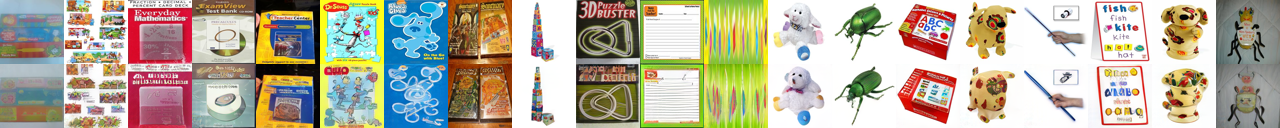

In [63]:
#tokenize_and_reconstruct("assets/ILSVRC2012_val_00008636.png")
import glob

images = [[], []]

for img_path in glob.glob("../seqrec/dataset/toys/images/*.jpg")[:20]:
    original, reconstructed = tokenize_and_reconstruct(img_path)
    images[0].append(original)
    images[1].append(reconstructed)

display_grid_images(images, 64)

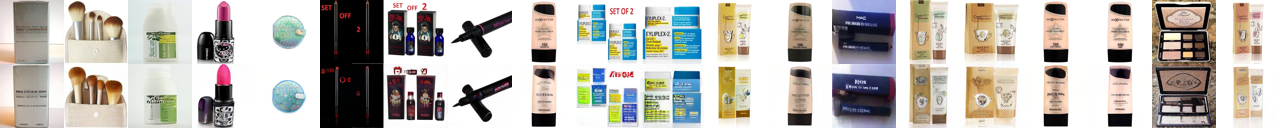

In [37]:
#tokenize_and_reconstruct("assets/ILSVRC2012_val_00008636.png")
import glob

images = [[], []]

for img_path in glob.glob("../seqrec/dataset/beauty/images/*.jpg")[:20]:
    original, reconstructed = tokenize_and_reconstruct(img_path)
    images[0].append(original)
    images[1].append(reconstructed)

display_grid_images(images, 64)

Input Image is represented by codes tensor([[[ 887, 3979,  349,  720, 2809, 2743, 2101,  603, 2205, 1508, 1891,
          4015, 1317, 2956, 3774, 2296,  484, 2612, 3472, 2330, 3140, 3113,
          1056, 3779,  654, 2360, 1901, 2908, 2169,  953, 1326, 2598]]],
       device='cuda:0') with shape torch.Size([1, 1, 32])
orginal image:


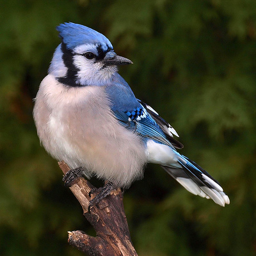

reconstructed image:


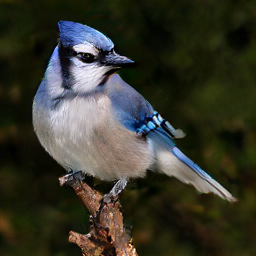

In [12]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00010240.png")

## Generate an image from 32 discrete tokens

labels 831, studio couch, day bed


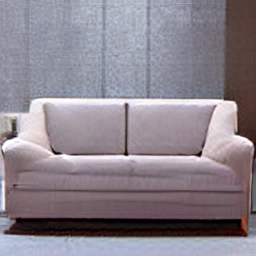

In [13]:
sample_labels = [torch.randint(0, 999, size=(1,)).item()]

# The guidance_scale and randomize_temperature can be adjusted to trade-off between quality and diversity.
generated_image = demo_util.sample_fn(
    generator=titok_generator,
    tokenizer=titok_tokenizer,
    labels=sample_labels,
    guidance_scale=3.5,
    randomize_temperature=1.0,
    num_sample_steps=8,
    device=device
)

for i in range(generated_image.shape[0]):
    print(f"labels {sample_labels[i]}, {imagenet_classes.imagenet_idx2classname[sample_labels[i]]}")
    display(Image.fromarray(generated_image[i]))